## Colab Setup

In [0]:
!pip install Pillow==4.1.1
!pip install --force-reinstall scipy
!pip install --force-reinstall pandas
!pip install prompt-toolkit==1.0.15


!pip install fastai==0.7.0 
!pip install torchtext==0.2.3


    100% |████████████████████████████████| 5.7MB 7.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 31.2MB 1.3MB/s 
    100% |████████████████████████████████| 13.9MB 3.8MB/s 
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
  Using cached https://files.pythonhosted.org/packages/e1/d8/feeb346d41f181e83fba45224ab14a8d8af019b48af742e047f3845d8cff/pandas-0.23.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ff/7f/9d804d2348471c67a7d8b5f84f9bc59fd1cefa148986f2b74552f8573555/numpy-1.15.4-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 235kB 7.5MB/s 
    100% |████████████████████████████████| 512kB 9.8MB/s 
  Found exis

## Style transfer

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
PATH = Path('data/imagenet')
PATH_TRN = PATH/'train'

In [0]:
!mkdir -p {PATH}
!wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
!tar xzf imagenet-sample-train.tar.gz -C {PATH}

--2018-12-05 12:21:34--  http://files.fast.ai/data/imagenet-sample-train.tar.gz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2232645974 (2.1G) [application/x-tar]
Saving to: ‘imagenet-sample-train.tar.gz’

imagenet-sample-tra 100%[===================>]   2.08G  15.9MB/s    in 2m 15s  

2018-12-05 12:23:50 (15.7 MB/s) - ‘imagenet-sample-train.tar.gz’ saved [2232645974/2232645974]



In [0]:
PATH_STYLE = PATH/'style'
style_fn = PATH_STYLE/'starry_night.jpg'

!mkdir -p {PATH_STYLE}
!cd {PATH_STYLE}; wget https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg

--2018-12-05 13:07:00--  https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 583974 (570K) [image/jpeg]
Saving to: ‘starry_night.jpg’

starry_night.jpg    100%[===================>] 570.29K  --.-KB/s    in 0.05s   

2018-12-05 13:07:00 (10.8 MB/s) - ‘starry_night.jpg’ saved [583974/583974]



In [0]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:55<00:00, 9966605.11it/s] 


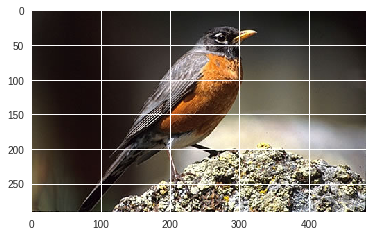

In [0]:
img_fn = PATH_TRN/'n01558993'/'n01558993_9684.JPEG'
img = open_image(img_fn)
plt.imshow(img);

In [0]:
sz=288

In [0]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

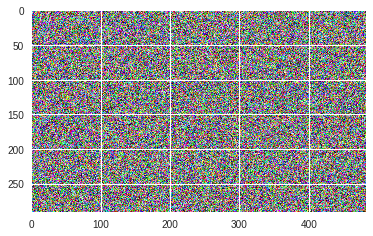

In [0]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [0]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

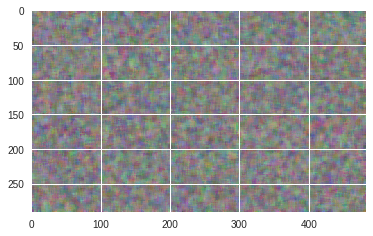

In [0]:
plt.imshow(opt_img);

In [0]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [1]:
??children

Object `children` not found.


In [0]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [0]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [0]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [0]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [0]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [0]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: 100, loss: 0.7861860990524292
Iteration: 200, loss: 0.33758071064949036
Iteration: 300, loss: 0.22464658319950104
Iteration: 400, loss: 0.17489799857139587
Iteration: 500, loss: 0.14667214453220367
Iteration: 600, loss: 0.12778300046920776
Iteration: 700, loss: 0.11338623613119125
Iteration: 800, loss: 0.10279904305934906
Iteration: 900, loss: 0.09465863555669785
Iteration: 1000, loss: 0.08842550963163376


In [0]:
def normalize(x):
  min_p = np.min(x)
  max_p =np.max(x)
  rng = max_p - min_p
  x = (x - min_p) / rng
  return x

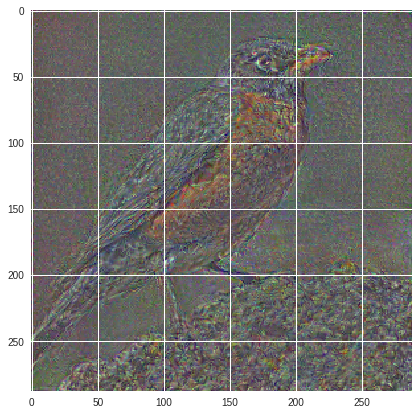

In [0]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
x=normalize(x)

plt.figure(figsize=(7,7))
plt.imshow(x);

## forward hook

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [0]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [0]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [0]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [0]:
opt_img_v, optimizer = get_opt()

In [0]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [0]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [0]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 100, loss: 0.019381793215870857
Iteration: 200, loss: 0.018226258456707
Iteration: 300, loss: 0.017228776589035988
Iteration: 400, loss: 0.016388775780797005
Iteration: 500, loss: 0.01563720777630806
Iteration: 600, loss: 0.014993682503700256
Iteration: 700, loss: 0.014420566149055958
Iteration: 800, loss: 0.013909746892750263
Iteration: 900, loss: 0.013461596332490444
Iteration: 1000, loss: 0.013054096139967442


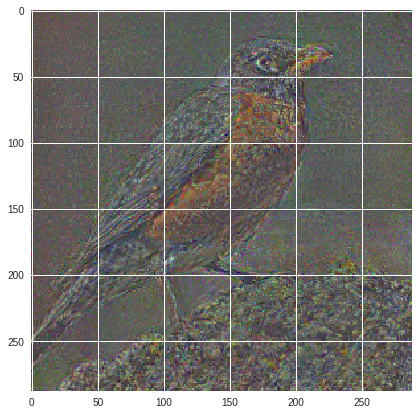

In [0]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
x=normalize(x)
plt.figure(figsize=(7,7))
plt.imshow(x);

In [0]:
sf.close()

## Style match

In [0]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((500, 800, 3), (291, 483, 3))

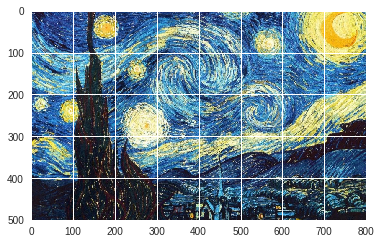

In [0]:
plt.imshow(style_img);

In [0]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [0]:
style = scale_match(img, style_img)

((291, 483, 3), (291, 483, 3))

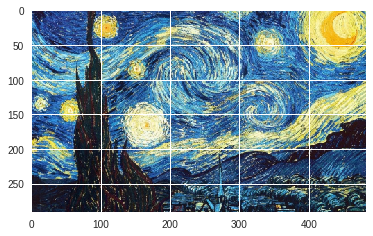

In [0]:
plt.imshow(style)
style.shape, img.shape

In [0]:
opt_img_v, optimizer = get_opt()

In [0]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [0]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [0]:
style_tfm = val_tfms(style_img)

In [0]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [0]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [0]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [0]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 100, loss: 616.472412109375
Iteration: 200, loss: 171.7813262939453
Iteration: 300, loss: 58.7192497253418
Iteration: 400, loss: 25.750186920166016
Iteration: 500, loss: 15.396989822387695
Iteration: 600, loss: 11.128137588500977
Iteration: 700, loss: 9.051407814025879
Iteration: 800, loss: 7.865011215209961
Iteration: 900, loss: 7.108098983764648
Iteration: 1000, loss: 6.582296848297119


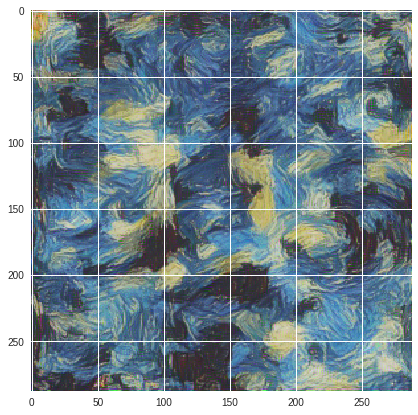

In [0]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
x=normalize(x)
plt.figure(figsize=(7,7))
plt.imshow(x);

In [0]:
for sf in sfs: sf.close()

## Style transfer

In [0]:
opt_img_v, optimizer = get_opt()

In [0]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [0]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [0]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 2525.5419921875
Iteration: 200, loss: 1500.4473876953125
Iteration: 300, loss: 1143.238525390625
Iteration: 400, loss: 973.9840087890625
Iteration: 500, loss: 882.5682983398438
Iteration: 600, loss: 830.3480224609375
Iteration: 700, loss: 798.044677734375
Iteration: 800, loss: 774.6279296875
Iteration: 900, loss: 757.2216186523438
Iteration: 1000, loss: 743.7086181640625


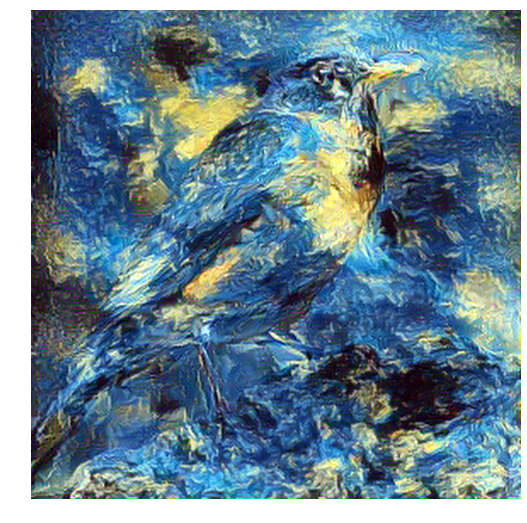

In [0]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [0]:
for sf in sfs: sf.close()